## 4a Numpyro Bayesian Fit for two component binding model
on simple simulated data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

Generate an ideal binding curve, with a little extra noise

In [2]:
# We define a Kd,
Kd = 2e-9 # M

# a protein concentration,
Ptot = 1e-9 * np.ones([12],np.float64) # M

# and a gradient of ligand concentrations for our experiment.
Ltot = 20.0e-6 / np.array([10**(float(i)/2.0) for i in range(12)]) # M

def two_component_binding(Kd, Ptot, Ltot):
    """
    Parameters
    ----------
    Kd : float
        Dissociation constant
    Ptot : float
        Total protein concentration
    Ltot : float
        Total ligand concentration
        
    Returns
    -------
    P : float
        Free protein concentration
    L : float
        Free ligand concentration
    PL : float
        Complex concentration
    """
                                    
    PL = 0.5 * ((Ptot + Ltot + Kd) - np.sqrt((Ptot + Ltot + Kd)**2 - 4*Ptot*Ltot))  # complex concentration (uM)
    P = Ptot - PL; # free protein concentration in sample cell after n injections (uM)                                                                                                                                                                                                                          
    L = Ltot - PL; # free ligand concentration in sample cell after n injections (uM)  
    
    return [P, L, PL]

[L, P, PL] = two_component_binding(Kd, Ptot, Ltot)

# Making max 1400 relative fluorescence units, and scaling all of PL (complex concentration) 
# to that, adding some random noise
npoints = len(Ltot)
sigma = 10.0 # size of noise
F_PL_i = 40 + (1400/1e-9)*PL + sigma * np.random.randn(npoints)

# make some simplifying assumptions without fluoresence of the ligand
"""
#Let's add an F_background just so we don't ever go below zero
F_background = 40
#We also need to model fluorescence for our ligand
F_L_i = F_background + (.4/1e-8)*Ltot + sigma * np.random.randn(npoints)

#Let's also add these to our complex fluorescence readout
F_PL_i = F_background + ((1400/1e-9)*PL + sigma * np.random.randn(npoints)) + ((.4/1e-8)*L + sigma * np.random.randn(npoints))
"""

# We know errors from our pipetting instruments.
P_error = 0.35
L_error = 0.08

assay_volume = 100e-6 # assay volume, L

dPstated = P_error * Ptot
dLstated = L_error * Ltot

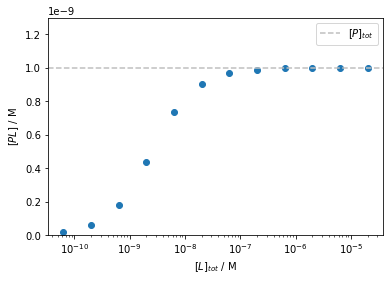

In [3]:
# [L]_tot vs [PL]

# y will be complex concentration
# x will be total ligand concentration
plt.semilogx(Ltot,PL, 'o')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$[PL]$ / M')
plt.ylim(0,1.3e-9)
plt.axhline(Ptot[0],color='0.75',linestyle='--',label='$[P]_{tot}$')
plt.legend()

No handles with labels found to put in legend.


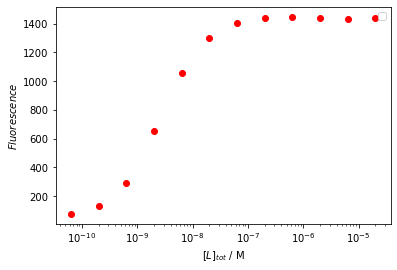

In [4]:
# [L]_tot vs fluoresence

# y will be complex concentration
# x will be total ligand concentration
plt.semilogx(Ltot,F_PL_i, 'ro')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$Fluorescence$')
plt.legend()

Run MCMC on the simulated data

In [5]:
from assaytools import numpyromodels

# num_warmup=10000, num_samples=20000, thinning=1
twocompbind = numpyromodels.MCMCModel(numpyromodels.toy_model)
twocompbind.run_mcmc(Ptot, dPstated, Ltot, dLstated, fluorescence=F_PL_i)

sample: 100%|██████████| 30000/30000 [00:44<00:00, 676.21it/s, 127 steps of size 2.15e-02. acc. prob=0.88]


In [6]:
import arviz as az
data = az.from_numpyro(twocompbind.mcmc)

[[<AxesSubplot:title={'center':'dG'}> <AxesSubplot:title={'center':'dG'}>]
 [<AxesSubplot:title={'center':'dispense_Ltrue'}>
  <AxesSubplot:title={'center':'dispense_Ltrue'}>]
 [<AxesSubplot:title={'center':'dispense_Ptrue'}>
  <AxesSubplot:title={'center':'dispense_Ptrue'}>]
 [<AxesSubplot:title={'center':'f_background'}>
  <AxesSubplot:title={'center':'f_background'}>]
 [<AxesSubplot:title={'center':'f_gain'}>
  <AxesSubplot:title={'center':'f_gain'}>]
 [<AxesSubplot:title={'center':'f_measure_var'}>
  <AxesSubplot:title={'center':'f_measure_var'}>]]


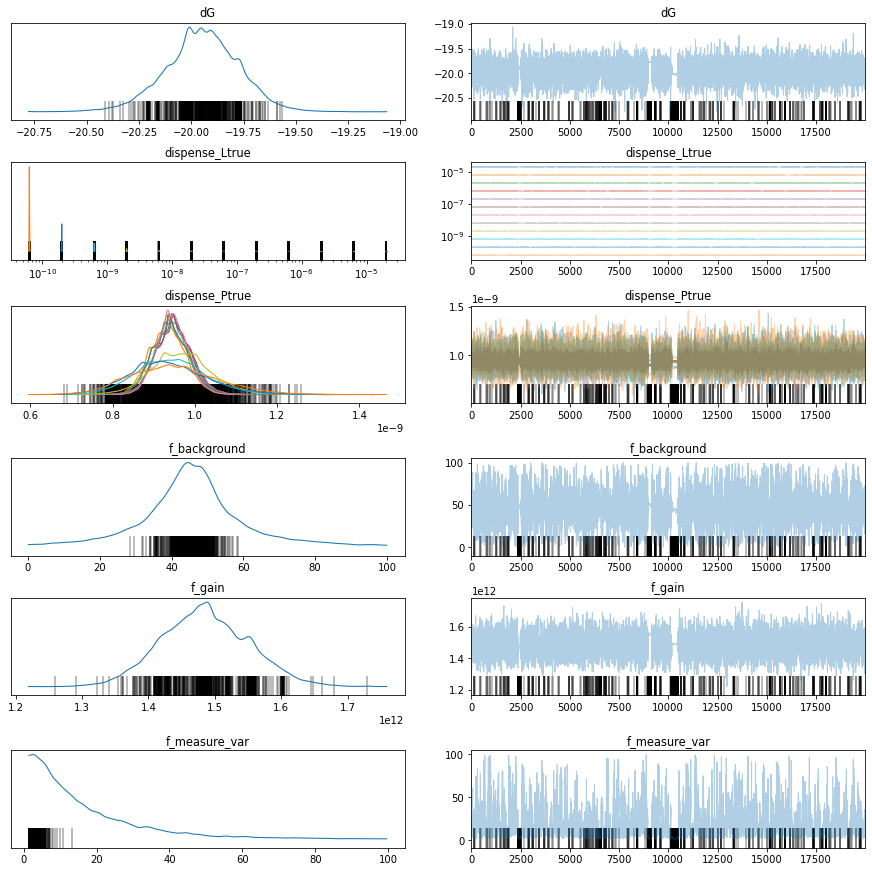

In [7]:
ax = az.plot_trace(data)
print(ax)
ax[1][0].set_xscale('log')
ax[1][1].set_yscale('log')


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
                dG    -19.95      0.18    -19.95    -20.24    -19.67   6694.24      1.00
 dispense_Ltrue[0]      0.00      0.00      0.00      0.00      0.00   1635.36      1.00
 dispense_Ltrue[1]      0.00      0.00      0.00      0.00      0.00   7827.24      1.00
 dispense_Ltrue[2]      0.00      0.00      0.00      0.00      0.00   7618.37      1.00
 dispense_Ltrue[3]      0.00      0.00      0.00      0.00      0.00  16909.19      1.00
 dispense_Ltrue[4]      0.00      0.00      0.00      0.00      0.00   3899.22      1.00
 dispense_Ltrue[5]      0.00      0.00      0.00      0.00      0.00   2839.73      1.00
 dispense_Ltrue[6]      0.00      0.00      0.00      0.00      0.00   8998.27      1.00
 dispense_Ltrue[7]      0.00      0.00      0.00      0.00      0.00   4013.99      1.00
 dispense_Ltrue[8]      0.00      0.00      0.00      0.00      0.00   5809.93      1.00
 dispense_Ltrue[9]  

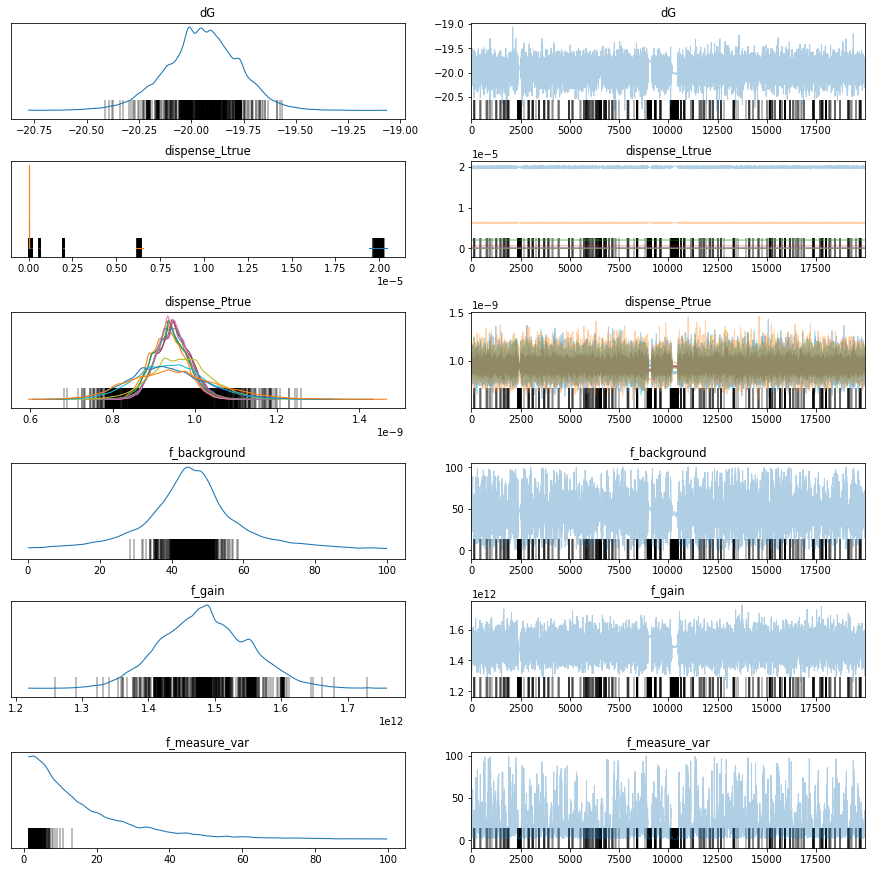

In [8]:
twocompbind.plot_results()

{'dG': DeviceArray(-19.984436, dtype=float32), 'dispense_Ltrue': DeviceArray([2.0138528e-05, 6.2547333e-06, 2.0006014e-06, 6.2747210e-07,
             2.0059976e-07, 6.3457890e-08, 1.9843000e-08, 6.3069434e-09,
             1.9970223e-09, 6.3348016e-10, 1.9915819e-10, 6.2910899e-11],            dtype=float32), 'dispense_Ptrue': DeviceArray([9.867667e-10, 9.783222e-10, 9.862210e-10, 9.937910e-10,
             9.918558e-10, 9.930408e-10, 9.863752e-10, 9.795247e-10,
             9.953542e-10, 9.546792e-10, 9.517576e-10, 8.908048e-10],            dtype=float32), 'f_background': DeviceArray(46.70745, dtype=float32), 'f_gain': DeviceArray(1.4143568e+12, dtype=float32), 'f_measure_var': DeviceArray(2.3207748, dtype=float32)}


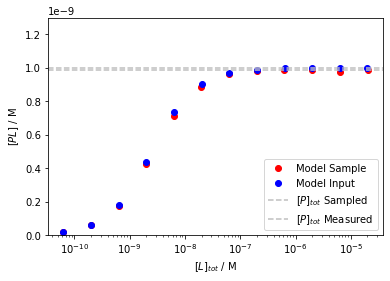

In [9]:
# plot results using a set of params sampled from the model

sample = {key: value[0] for key, value in twocompbind.mcmc.get_samples().items()}
print(sample)
Lsample = sample['dispense_Ltrue']
Psample = sample['dispense_Ptrue']
dGsample = sample['dG']
[L_s, P_s, PL_s] = two_component_binding(jnp.exp(dGsample), Psample, Lsample)

# y will be complex concentration
# x will be total ligand concentration
plt.semilogx(Lsample,PL_s, 'ro', label="Model Sample")
plt.semilogx(Ltot,PL, 'bo', label="Model Input")
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$[PL]$ / M')
plt.ylim(0,1.3e-9)
plt.axhline(Psample[0],color='0.75',linestyle='--',label='$[P]_{tot}$ Sampled')
plt.axhline(Ptot[0],color='0.75',linestyle='--',label='$[P]_{tot}$ Measured')
plt.legend()

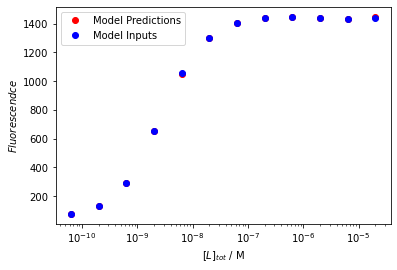

In [10]:
# plot the model's predictions on the original data to see how closely it matches

predictions = twocompbind.predict(Ptot, dPstated, Ltot, dLstated)
plt.semilogx(Ltot, predictions['measure_fluorescence'][0], 'ro', label="Model Predictions")
plt.semilogx(Ltot,F_PL_i, 'bo', label="Model Inputs")
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$Fluorescendce$')
plt.legend()